In [1]:
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras 
import warnings

warnings.filterwarnings('ignore')
print(tf.__version__)
for model in sklearn, pd, keras, np ,mlp:
    print(model.__name__, model.__version__)

2.1.0
sklearn 0.20.2
pandas 0.24.2
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf
numpy 1.17.4
matplotlib 2.1.2


In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
housing = fetch_california_housing()
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=2)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [3]:
# version 0.2 数据归一化
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
x_train = std.fit_transform(x_train)
x_valid = std.transform(x_valid)
x_test = std.transform(x_test)

In [4]:
output_dir = "generate_csv"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
def save_to_csv(output_dir, data, name_prefix, header=None, n_parts=10):
    path_format = os.path.join(output_dir, "{}_{:02d}.csv")
    filenames = []
    for file_idx, row_indices in enumerate(np.array_split(np.arange(len(data)), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filenames.append(part_csv)
        with open(part_csv, "wt") as f:
            if header is not None:
                f.write(header + "\n")
            for row_index in row_indices:
                f.write(",".join([repr(col) for col in data[row_index]]))
                f.write("\n")
    return filenames

train_data = np.c_[x_train, y_train]
valid_data = np.c_[x_valid, y_valid]
test_data = np.c_[x_test, y_test]
header_cols = housing.feature_names + ["MidianHouseValue"]
header_str = ",".join(header_cols)

# 调用一下
train_filenames = save_to_csv(output_dir, train_data, "train", header_str, n_parts=20)
valid_filenames = save_to_csv(output_dir, valid_data, "valid", header_str, n_parts=10)
test_filenames = save_to_csv(output_dir, test_data, "test", header_str, n_parts=10)

In [5]:
# 按行进行解析
def parse_csv_line(line, n_files=9):
    defs = [tf.constant(np.nan)] * n_files
    parsed_files = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(parsed_files[0: -1])
    y = tf.stack(parsed_files[-1:])
    return x, y

In [6]:
# 将整个过程整合成一个函数
def csv_reader_dateset(filenames, n_reader=5, batch_size=32, n_parse_threads=5, shuffle_buffer_size=10000):
    # 将文件名字进行合并
    dataset = tf.data.Dataset.list_files(filenames)
    # 对数据集进行无限次重复
    dataset = dataset.repeat()
    # 按行读取每个文件，并跳过第一行，将读取的数据，合并成一个数据集
    dataset = dataset.interleave(
        lambda filename: tf.data.TextLineDataset(filename).skip(1),
        cycle_length=n_reader
    )
    # shuffle
    dataset.shuffle(shuffle_buffer_size)
    # 将字符串转化成需要的类型（Tensor）,将数据中每行数据传给'parse_csv_line'，并行处理
    dataset = dataset.map(parse_csv_line, num_parallel_calls=n_parse_threads)
    # 按batch 生成数据
    dataset = dataset.batch(batch_size)
    return dataset
    
# 简单测试一下
import pprint
trainset = csv_reader_dateset(train_filenames, batch_size=4)
for x, y in trainset.take(3):
    pprint.pprint(x)
    pprint.pprint(y)

<tf.Tensor: shape=(4, 8), dtype=float32, numpy=
array([[-1.35126102e+00,  1.11294657e-01,  1.12158895e+00,
         1.93051875e+00, -1.15190125e+00, -8.89746919e-02,
        -6.70757830e-01,  2.02953243e+00],
       [-7.85175741e-01,  1.21953666e+00, -5.57945311e-01,
         1.02853246e-01, -1.93127066e-01,  2.42305305e-02,
        -7.22014666e-01,  7.07786083e-01],
       [-2.78776318e-01,  2.69614935e-01, -4.45636868e-01,
        -9.52067673e-02,  1.23174262e+00, -2.79986411e-02,
        -7.26674438e-01,  7.62444735e-01],
       [ 9.63677406e-01,  3.48775089e-01,  6.09247744e-01,
        -6.16605356e-02,  9.39735398e-02,  1.78335398e-03,
        -1.39767349e+00,  1.26431084e+00]], dtype=float32)>
<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.425],
       [1.522],
       [2.141],
       [2.346]], dtype=float32)>
<tf.Tensor: shape=(4, 8), dtype=float32, numpy=
array([[ 0.03283366,  0.50709534,  0.00174462, -0.22257158, -0.7035281 ,
         0.01396988, -0.7453133 ,  0.8320

In [7]:
batch_size = 32
train_set = csv_reader_dateset(filenames=train_filenames, batch_size=batch_size)
valid_set = csv_reader_dateset(filenames=valid_filenames, batch_size=batch_size)
test_set = csv_reader_dateset(filenames=test_filenames, batch_size=batch_size)

In [8]:
# tf.keras.models.Sequential()
# version dnn, 多层神经网络，循环添加层次。
model = tf.keras.models.Sequential([
    keras.layers.Dense(30,activation='relu',input_shape=[8]),
    keras.layers.Dense(1),
])

# sparse_categorical_crossentropy:  如果y是一个数，会把它转化成一个向量，如 y->index., y->one hot->[]
model.compile(loss='mean_squared_error',
              optimizer='adam')


In [9]:
# version 0.3 回调函数
# Tensorboard, Earlystopping, Modelcheckpoint
logdir = './reg_callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "housing_model.h5")

callbacks = [
#     keras.callbacks.TensorBoard(logdir),
#     keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(train_set, 
                    epochs=100,
                    steps_per_epoch = 11160 // batch_size,
                    validation_steps = 3870 // batch_size,
                    validation_data=valid_set,
                    callbacks=callbacks)

Train for 348 steps, validate for 120 steps
Epoch 1/100
348/348 [==============================] - 1s 2ms/step - loss: 2.0161 - val_loss: 0.6846
Epoch 2/100
348/348 [==============================] - 1s 2ms/step - loss: 0.6234 - val_loss: 0.5238
Epoch 3/100
348/348 [==============================] - 1s 2ms/step - loss: 0.4901 - val_loss: 0.4580
Epoch 4/100
348/348 [==============================] - 1s 1ms/step - loss: 0.4425 - val_loss: 0.4341
Epoch 5/100
348/348 [==============================] - 0s 1ms/step - loss: 0.4296 - val_loss: 0.4122
Epoch 6/100
348/348 [==============================] - 0s 1ms/step - loss: 0.4200 - val_loss: 0.4002
Epoch 7/100
348/348 [==============================] - 1s 1ms/step - loss: 0.3943 - val_loss: 0.3889
Epoch 8/100
348/348 [==============================] - 1s 2ms/step - loss: 0.3894 - val_loss: 0.3828
Epoch 9/100
348/348 [==============================] - 1s 1ms/step - loss: 0.3890 - val_loss: 0.3800
Epoch 10/100
348/348 [=========================

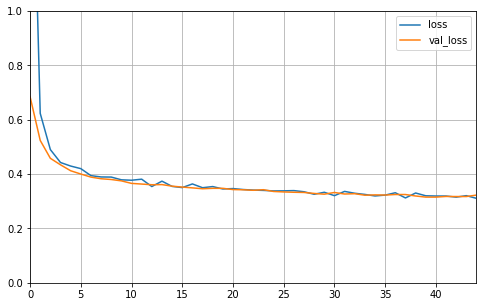

In [12]:
def plot_learning_curve(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curve(history)

In [13]:
model.evaluate(test_set, steps=5160 // batch_size)

161/161 [==============================] - 0s 1ms/step - loss: 0.3428


0.3427965116241704

In [14]:
10 // 3

3